In [4]:
import pandas as pd
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.express as px
from helper import *
from features_extractor import CreditFeatureExtractor,feature_descriptions
import math



## 1. Feature Engineering from `credit_report_sample.json`

The objective of this analysis is to extract and engineer all relevant features from the `credit_report_sample.json` dataset.

In [24]:
with open("credit_data/credit_report_sample.json","r") as file:
    json_data = json.load(file) 
    

In [25]:
extractor = CreditFeatureExtractor(feature_descriptions)
features_df = extractor.extract_features(json_data)

In [26]:
features_df.columns

Index(['application_id', 'total_debt', 'credit_score', 'amount_arrear',
       'total_monthly_installment', 'num_accounts', 'num_open_accounts',
       'num_closed_accounts', 'num_performing_accounts',
       'num_non_performing_accounts', 'avg_credit_line', 'employment_status'],
      dtype='object')

In [27]:
features_df

,application_id,total_debt,credit_score,amount_arrear,total_monthly_installment,num_accounts,num_open_accounts,num_closed_accounts,num_performing_accounts,num_non_performing_accounts,avg_credit_line,employment_status
0,9711360,105435.0,13.0,24041.0,77404.0,7,3,1,7,0,228454.142857,PUBLIC SERVANTS
1,9714953,294770.0,2.0,0.0,132176.0,17,4,10,17,0,36564.705882,CIVIL SERVANT
2,9714978,110919.0,109.0,12000.0,7000.0,3,3,0,2,1,363645.333333,STUDENT


In [28]:
extractor.display_feature_relevance()

                                         Feature Relevance to Risk Scoring                                         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                           ┃                                                                                     ┃
┃ Feature Name              ┃ Relevance to Risk Scoring                                                           ┃
┃                           ┃                                                                                     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                           │                                                                                     │
│ total_debt                │ Reflects overall indebtedness. Higher debt strongly correlates with increased       │
│                           │ default risk. A high total debt compared to income indicates...                     │
│                           │                                                                                     │
│                           │                                                                                     │
│ credit_score              │ A fundamental indicator of creditworthiness derived from credit bureau data. Lower  │
│                           │ scores directly indicate a higher risk of default, reflecting a...                  │
│                           │                                                                                     │
│                           │                                                                                     │
│ arrear_amount             │ Directly indicates financial distress. Higher amounts in arrears are a very strong  │
│                           │ predictor of default, signaling an immediate inability to meet...                   │
│                           │                                                                                     │
│                           │                                                                                     │
│ total_monthly_payment     │ Represents the borrower's total monthly debt obligations across all credit          │
│                           │ accounts. A high value relative to income indicates potential financial...          │
│                           │                                                                                     │
│                           │                                                                                     │
│ num_total_accounts        │ The total number of credit accounts held by the borrower, including both open and   │
│                           │ closed accounts. A higher number can sometimes indicate higher...                   │
│                           │                                                                                     │
│                           │                                                                                     │
│ num_open_accounts         │ The number of currently open credit accounts. A large number of open accounts could │
│                           │ suggest the borrower is actively taking on more debt,...                            │
│                           │                                                                                     │
│                           │                                                                                     │
│ num_closed_accounts       │ The number of closed credit accounts. Can provide insights into the borrower's past │
│                           │ credit behavior and financial management. A large number of...                      │
│                           │                                                                                     │
│                           │                           

## 2. Default Prediction Modeling using `credit.csv`

The following steps outline the modeling process for predicting customer defaulting behavior using the `credit.csv` dataset:

*   **Exploratory Data Analysis (EDA):** Conduct a thorough EDA to understand the data's characteristics and identify potential patterns.
*   **Model Training:** Train a predictive model to classify customers based on their likelihood of defaulting.
*   **Scoring Function Justification:** Clearly justify the selection of appropriate scoring function(s) for model evaluation.
*   **Model Evaluation and Interpretation:** Evaluate the model's performance, interpret the results, and provide a detailed discussion of the findings.
*   **Business Impact Assessment:** Estimate the potential business impact of deploying the trained model in decision-making processes.

### 2.1 Exploratory Data Analysis (EDA)


In [5]:
df_csv =  pd.read_csv("credit_data/credit.csv")
df = df_csv.copy() 
#Calculate the number of unique values in each column
print(df.nunique())
#find null/missing values from datset
null_count = df.isnull().sum()
total_values = len(df)
null_percentage = (null_count / total_values) * 100
# print(null_percentage)
df.drop(['Unnamed: 0','telephone'],axis=1,inplace=True)



Unnamed: 0              1000
checking_balance         263
months_loan_duration      33
credit_history             5
purpose                   10
amount                   921
savings_balance          302
employment_length         31
installment_rate           4
personal_status            3
other_debtors              3
residence_history         36
property                   4
age                       53
installment_plan           3
housing                    3
existing_credits           4
default                    2
dependents                 2
telephone                404
foreign_worker             2
job                        4
gender                     2
dtype: int64


#### Feature Engineering 


In [6]:
#Replace all NaN values of checking_balance with zero
df['checking_balance'] = df['checking_balance'].replace(np.nan,0)
df['savings_balance'] = df['savings_balance'].replace(np.nan,0)
df['personal_status'] = df['personal_status'].replace(0, 'single')
df['personal_status'] = df['personal_status'].replace(np.nan, 'single')
df['residence_history'] = df['residence_history'].replace(np.nan, '0 months')
df['residence_history'] = df['residence_history'].apply(to_months)
df['employment_length'] = df['employment_length'].replace(np.nan, '0 months')
df['employment_length']=df['employment_length'].apply(to_months)


In [7]:
df['employment_length_category'] = pd.cut(df['employment_length'], employment_length_category[0], labels=employment_length_category[1], right=True,include_lowest=True)
df['savings_balance_category'] = pd.cut(df['savings_balance'], savings_balance_category[0], labels=savings_balance_category[1], right=True, include_lowest=True)
df['purpose'] = df['purpose'].map(purpose_category_mapping)
df['Target']=df['default'].map({0:"good",1:"bad"})


In [8]:
df.drop(['other_debtors','installment_plan','employment_length','savings_balance'],axis=1,inplace= True)

In [9]:
df.columns

Index(['checking_balance', 'months_loan_duration', 'credit_history', 'purpose',
       'amount', 'installment_rate', 'personal_status', 'residence_history',
       'property', 'age', 'housing', 'existing_credits', 'default',
       'dependents', 'foreign_worker', 'job', 'gender',
       'employment_length_category', 'savings_balance_category', 'Target'],
      dtype='object')

#### Numerical Variables Analysis


In [10]:
numerical = ['checking_balance','months_loan_duration' ,'amount', 'age','residence_history']


C:\Users\Kmuds\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Kmuds\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Kmuds\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Kmuds\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

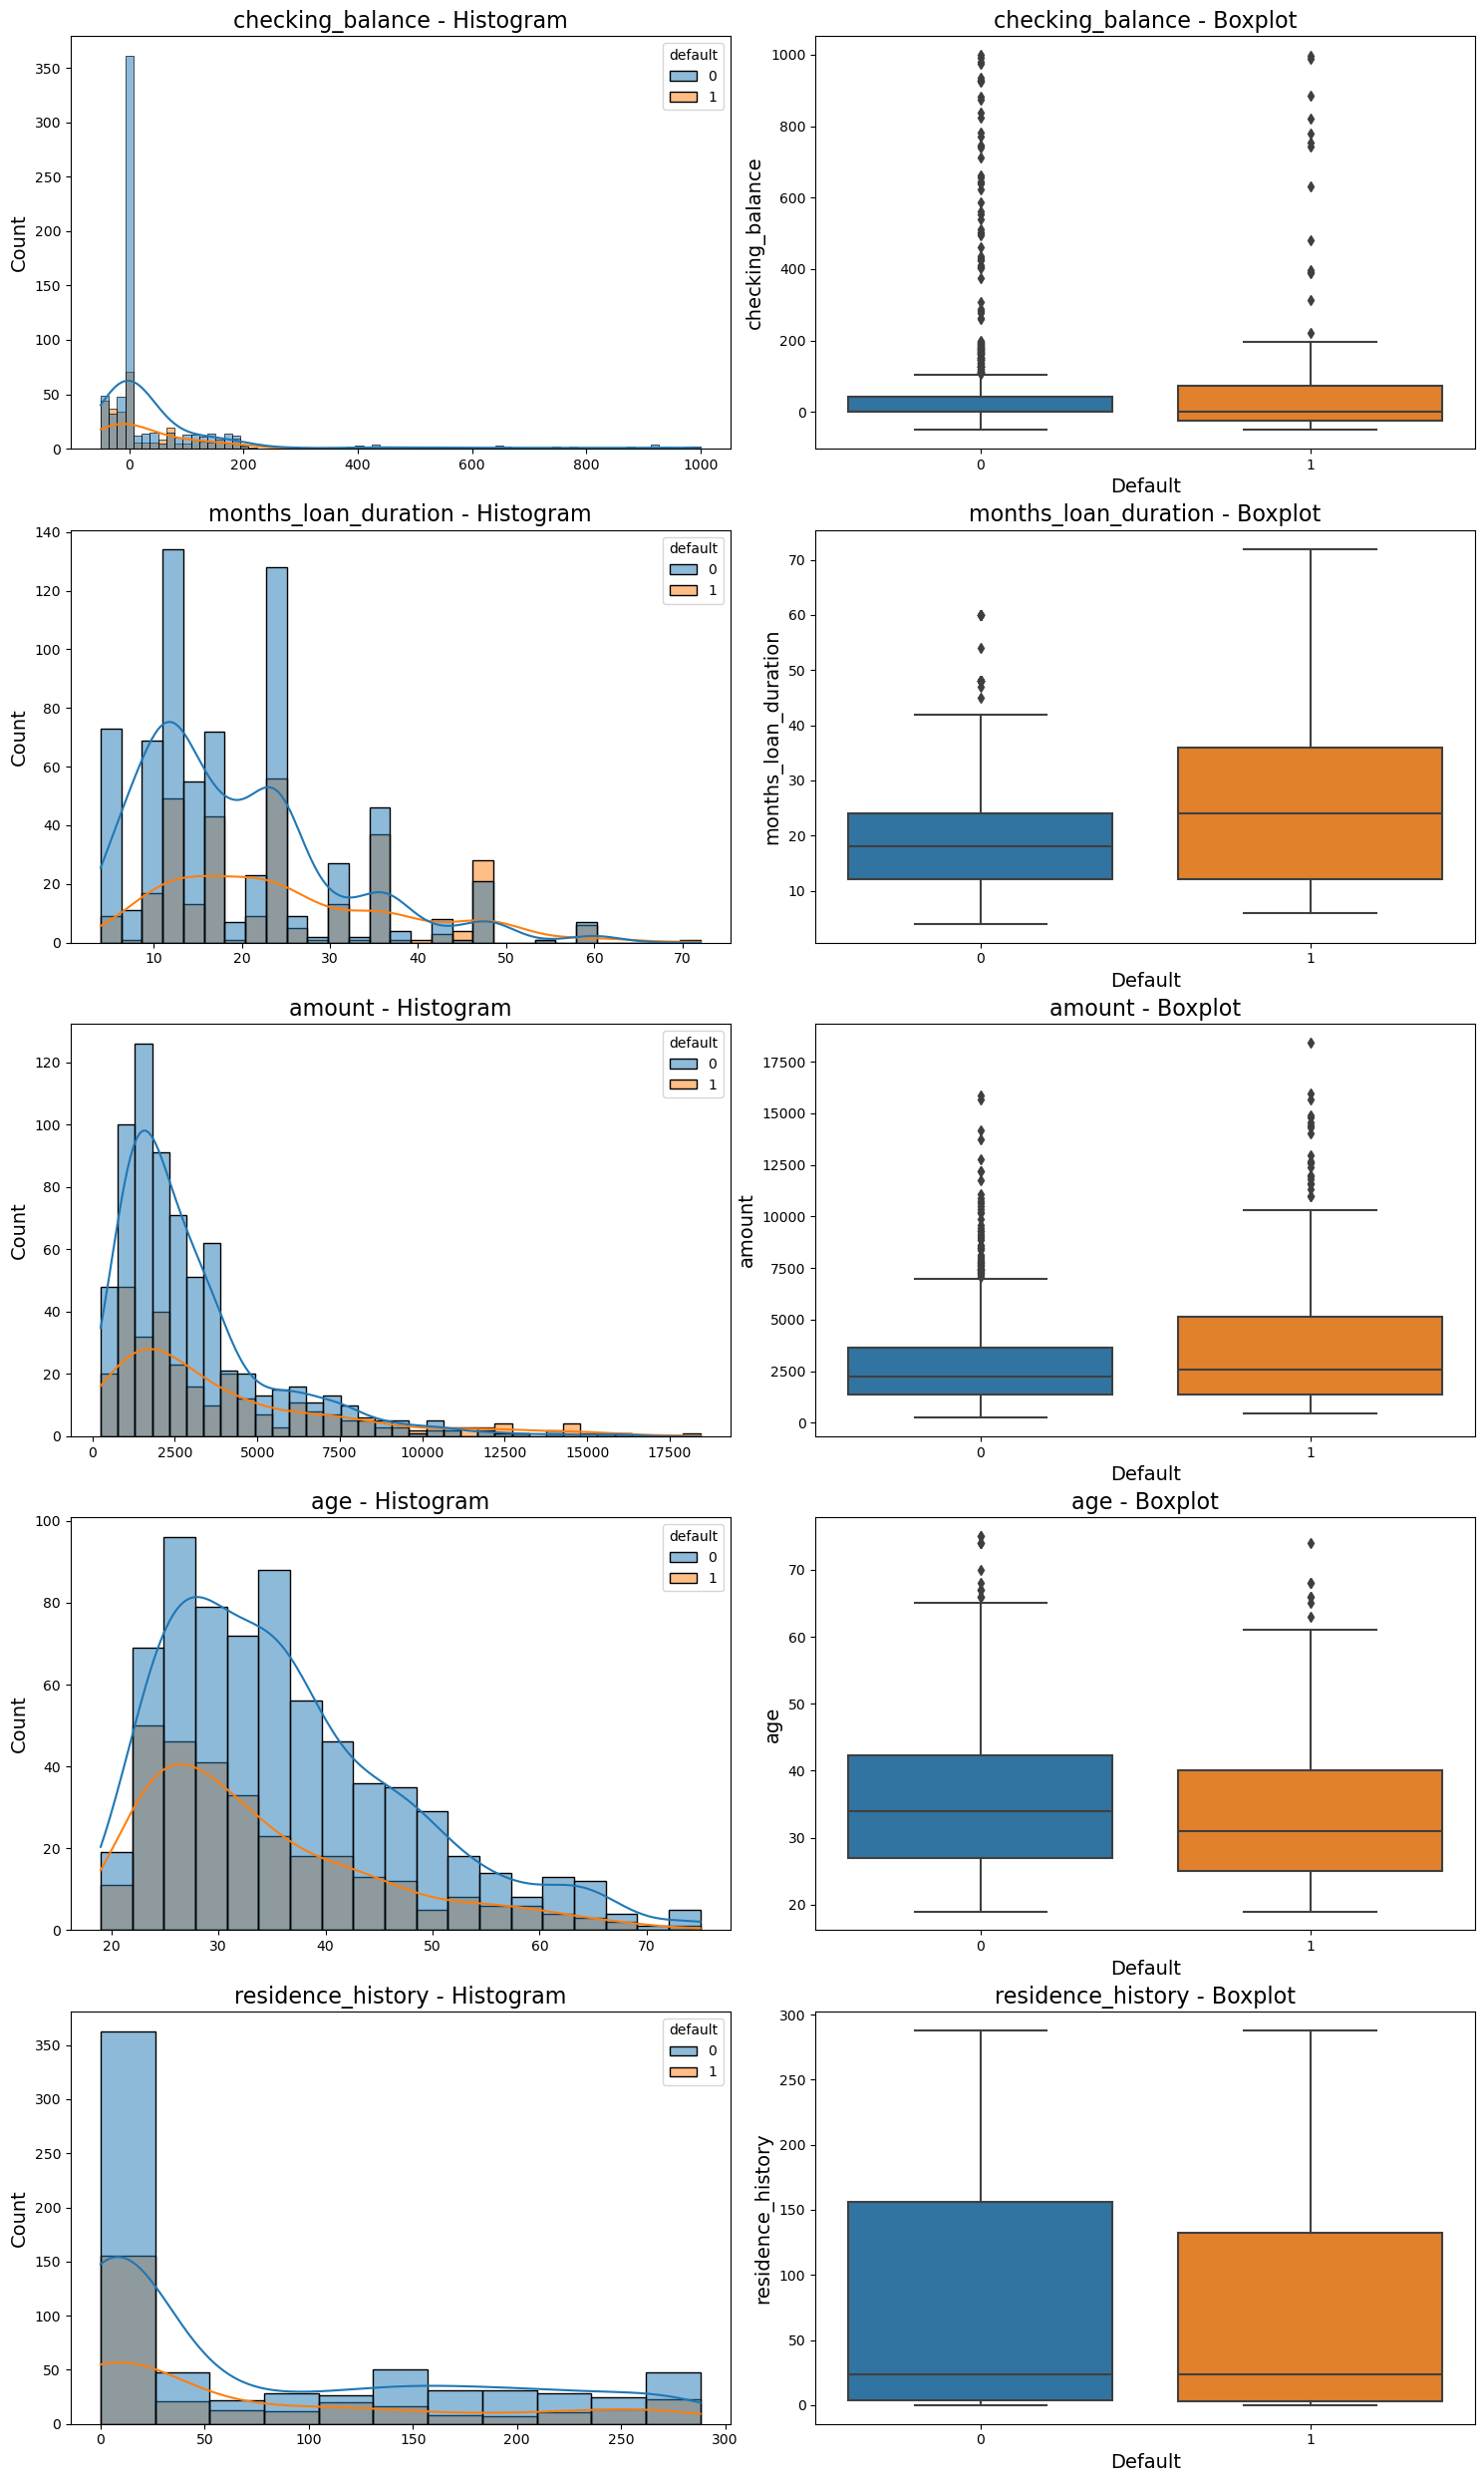

In [11]:
numerical_varaible_analysis(df,numerical)

* #### Months Loan Duration
histogram indicates that the majority of loans are concentrated in the lower duration categories (0-30 months). 
This could imply that customers prefer shorter loan durations, possibly due to lower interest costs or quicker repayment cycles.

* #### Age Distribution;
The age histogram shows a typical distribution, with most customers falling within the 30-50 age range. This demographic could be targeted for specific financial products tailored to their life stage.



#### Categorical Variables Analysis



In [12]:
categorical = [col for col in df.columns if col not in numerical]


In [13]:
categorical=['credit_history','purpose','installment_rate','personal_status','property', 'housing', 'existing_credits','dependents',
 'job','gender','employment_length_category','savings_balance_category']

C:\Users\Kmuds\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\Kmuds\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\Kmuds\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
 

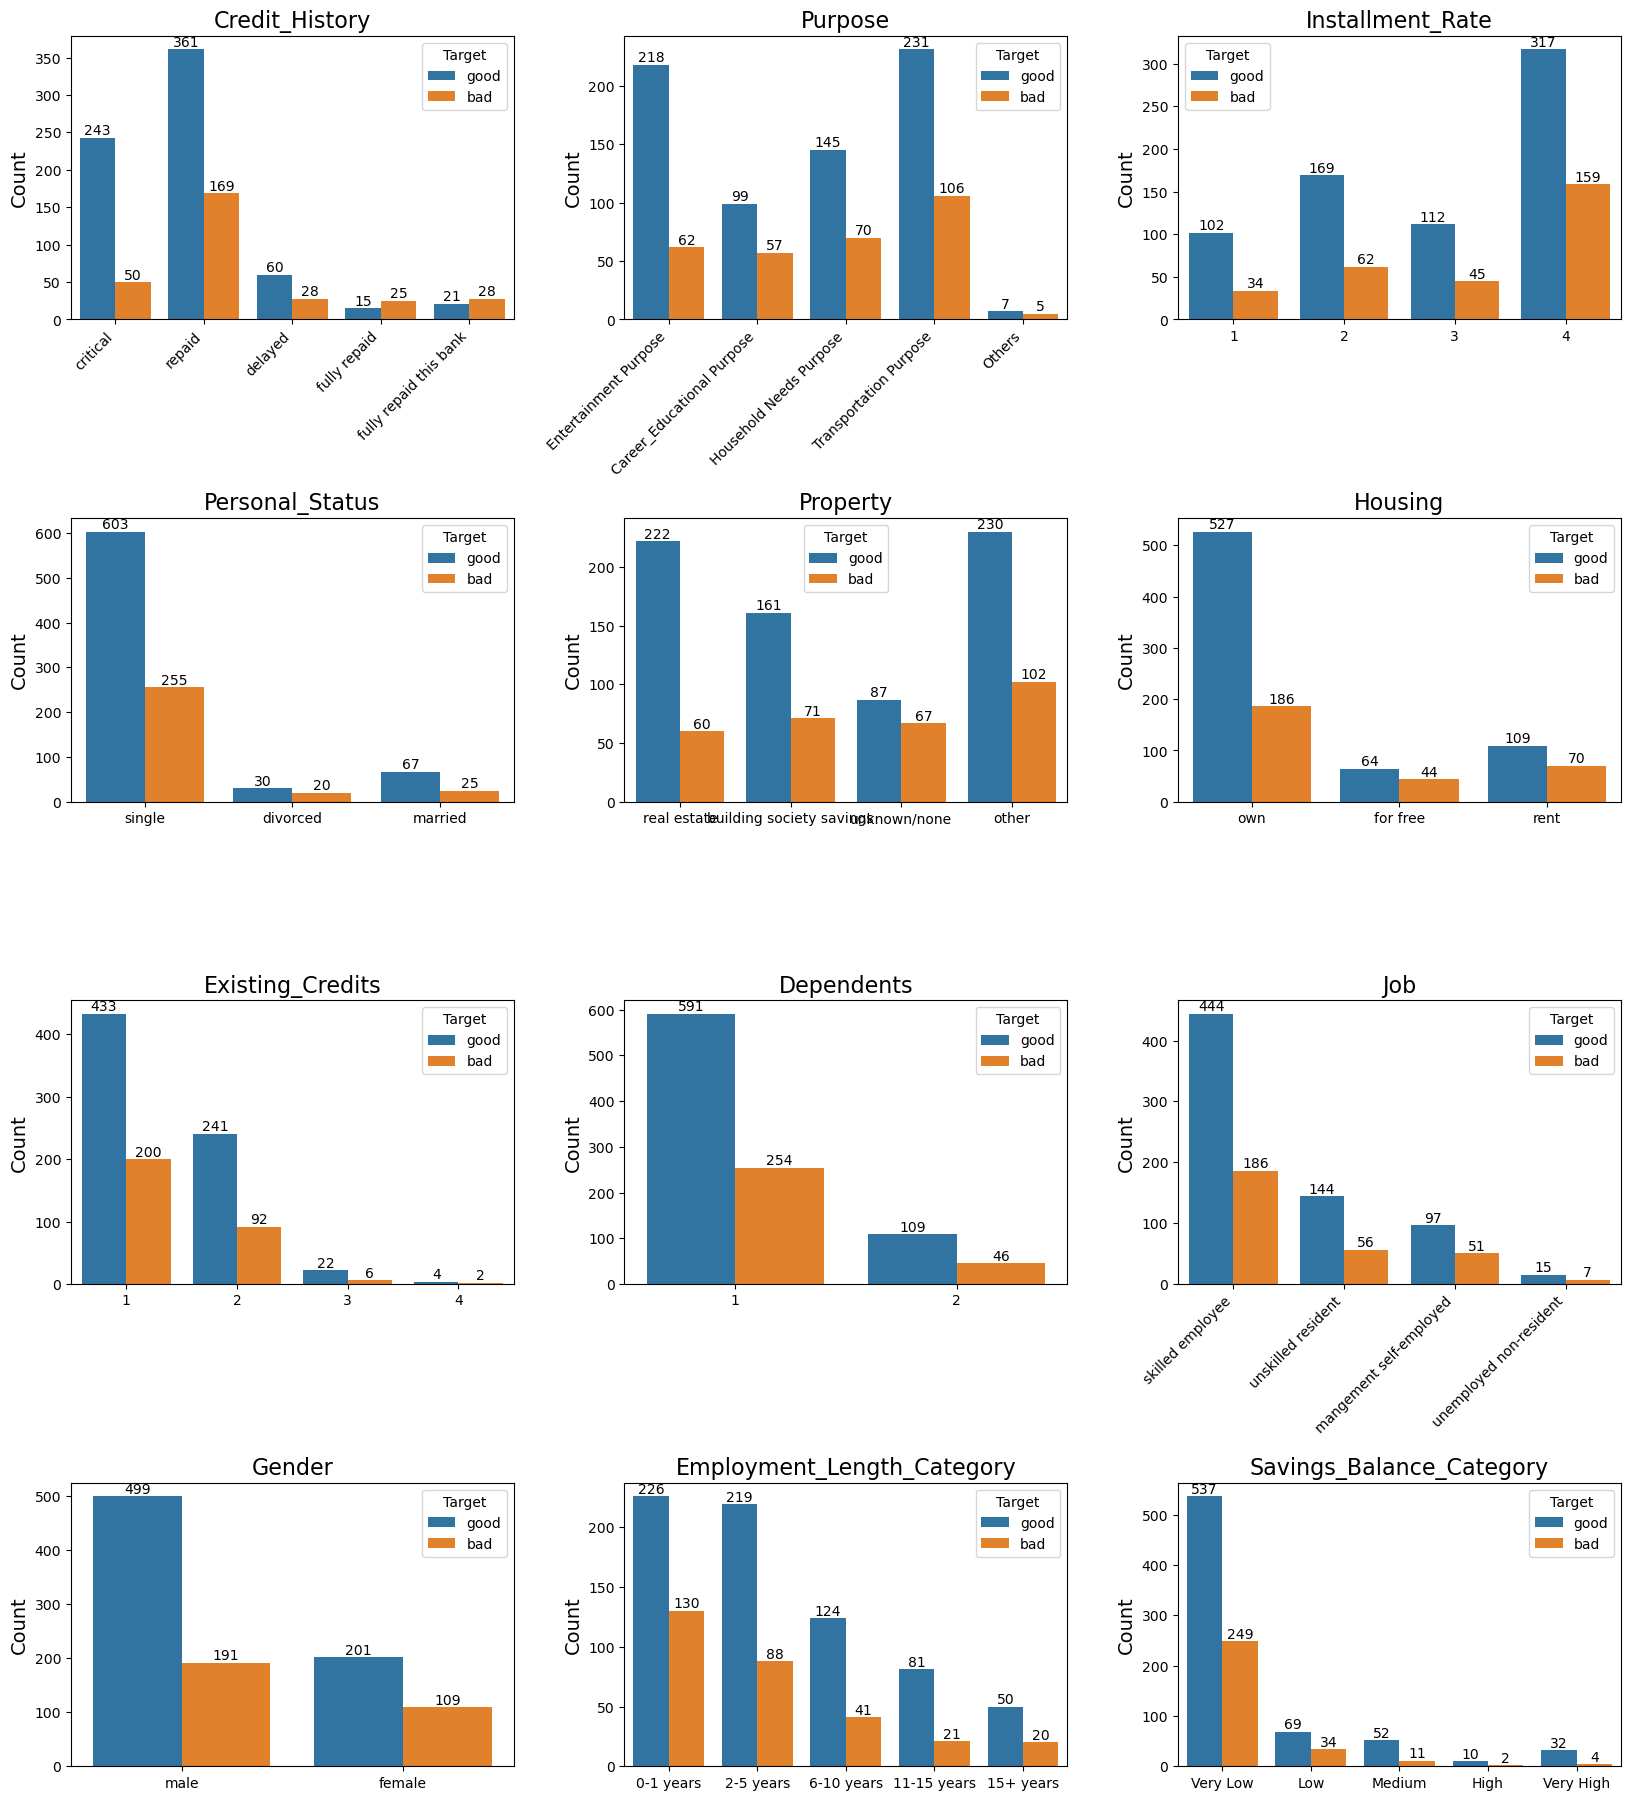

In [14]:
categorical_variables_analysis(df,categorical)

#### Identify Features with the strongest Correlation to Credit Risk


In [ ]:
oe = OrdinalEncoder(dtype=np.int64)
df[categorical] = oe.fit_transform(df[categorical])


In [ ]:
df.columns

In [ ]:
df.drop('Target',axis=1,inplace=True)

In [ ]:
# Generate feature correlation
corr = df.corr(method='spearman').round(2)

# Visualize correlation
corr_heatmap = px.imshow(corr,
                         text_auto=True,
                         labels=dict(x="Features", y="Features",
                                     color="Correlation"),
                         color_continuous_scale=px.colors.sequential.RdBu,
                         title="Linear Correlation (Heatmap)",
                         height=1000
                         )

corr_heatmap.update_layout(
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    xaxis_title="Features",
    yaxis_title="Features",
    coloraxis_colorbar_title="Correlation"
)

corr_heatmap.show()

**Correlation Analysis:**

The following key correlations were observed in the data:

1.  **Amount and Months Loan Duration (0.62):** A strong positive correlation exists between loan amount and loan duration. This is expected; larger loans often necessitate longer repayment periods.  This multicollinearity should be considered during feature engineering or modeling.

2.  **Housing and Savings Balance Category (-0.22):**  A moderate negative correlation suggests that individuals who own their own house tend to have higher savings balance categories.

3.  **Age and Savings Balance Category (0.2):** A weak positive correlation indicates a tendency for older individuals to have higher savings balance categories.

4.  **Personal Status and Gender (-0.27):** This negative correlation likely reflects the encoding of these categorical variables (e.g., single/married and male/female) and suggests a potential relationship between marital status and gender within thationship.

5.  **Credit History and Existing Credits (-0.62):** A strong negative correlation exists between credit history and the number of existing credits. This is logical, as a good credit history typically leads to access to more credit, resulting in a higher number of existing credit accounts.g credits.


# **Key Takeaways for Modeling:**

*   **Prioritize Credit History:** `credit_history` is an important predictor of default and should be a key feature in any model.

*   **Consider Key Financial and Loan-Related Features:** `months_loan_duration`, `amount`, `installment_rate`, and `savings_balance_category` are relevant features related to the loan terms and the applicant's financial situation. These features show moderate importance and could contribute to model performance.

*   **Other Potentially Useful Features:** `checking_balance`, `age`, and `residence_history` are identified as important features by the model. These relate to the applicant's current financial status and personal circumstances, and warrant consideration in the model.

# 2.2 Model Training


In [23]:
df.head()

,checking_balance,months_loan_duration,amount,residence_history,age,default,credit_history_critical,credit_history_delayed,credit_history_fully repaid,credit_history_fully repaid this bank,...,employment_length_category_0-1 years,employment_length_category_11-15 years,employment_length_category_15+ years,employment_length_category_2-5 years,employment_length_category_6-10 years,savings_balance_category_High,savings_balance_category_Low,savings_balance_category_Medium,savings_balance_category_Very High,savings_balance_category_Very Low
0,-0.607395,-1.236478,-0.745131,-0.072560,2.766456,0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.095753,2.248194,0.949817,-0.788545,-1.191404,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.351163,-0.738668,-0.416562,-0.329033,1.183312,0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.541847,1.750384,1.634247,0.825093,0.831502,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.488217,0.256953,0.566664,0.825093,1.535122,1,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [17]:
df.drop(['foreign_worker','Target'],axis=1,inplace=True)

In [18]:
categorical_columns =['credit_history','purpose','installment_rate','personal_status','property','housing','existing_credits',
 'dependents','job','gender','employment_length_category','savings_balance_category']

df = feature_encoding(df,categorical_columns,numerical)

In [19]:
X_train, X_test, y_train, y_test = prepare_data_pipeline(df)

In [19]:
model = train_model(X_train, y_train,X_test, y_test)

In [20]:
model = load_catboost_model('catboost')

In [15]:
#model.save_model("catboost")

## Model Evaluation Metrics:


              precision    recall  f1-score   support

           0       0.88      0.81      0.84       144
           1       0.81      0.88      0.84       132

    accuracy                           0.84       276
   macro avg       0.85      0.85      0.84       276
weighted avg       0.85      0.84      0.84       276

AUC :  93.54%
Sensitivity_recall :  87.97%
Specificity:  81.12%
Precision:  81.25%
Accuracy:  84.42%


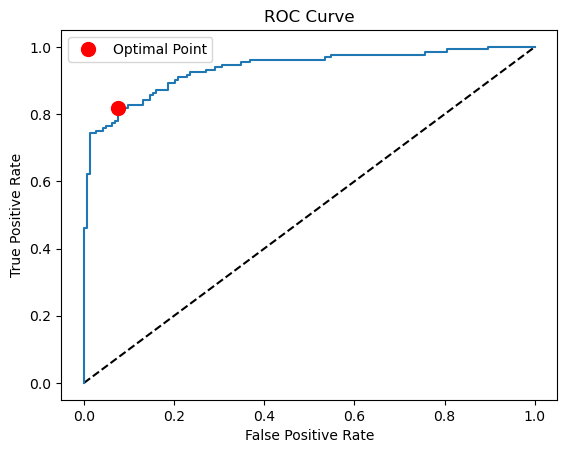

{'accuracy': 0.8442028985507246,
 'beta_score': 0.8643815201192251,
 'f1_score': 0.8436363636363636,
 'sensitivity_recall': 0.8796992481203008,
 'specificity': 0.8111888111888111,
 'precision': 0.8125,
 'auc_score': 0.9353956228956228,
 'optimal_threshold': fpr_cat     0.076389
 tpr_cat     0.818182
 Distance    0.197213
 Name: 18, dtype: float64}

In [21]:
evaluate_model(model, X_test, y_test)

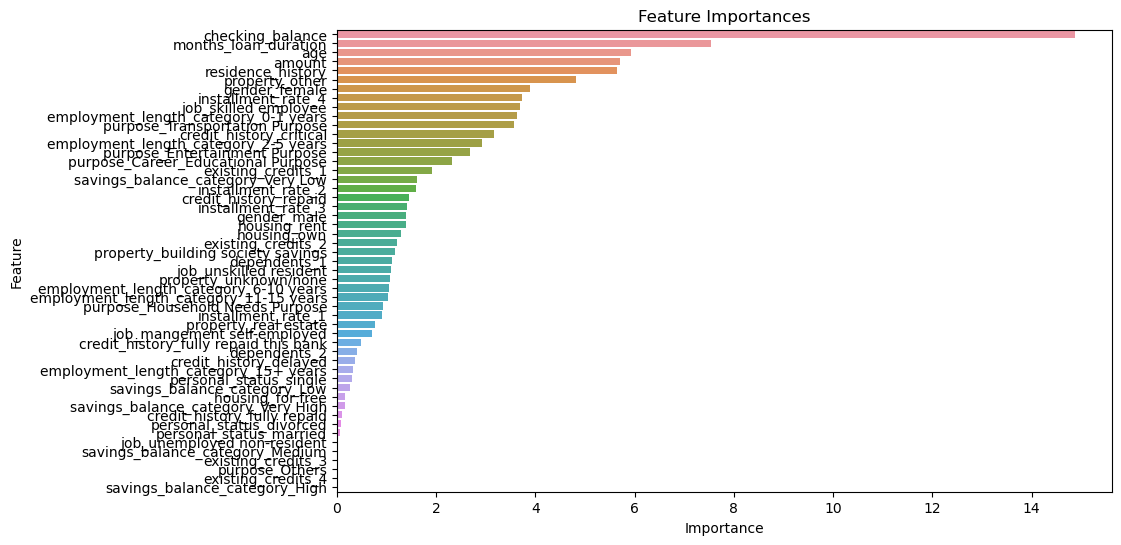

PermutationExplainer explainer: 277it [00:19,  7.95it/s]                                                               


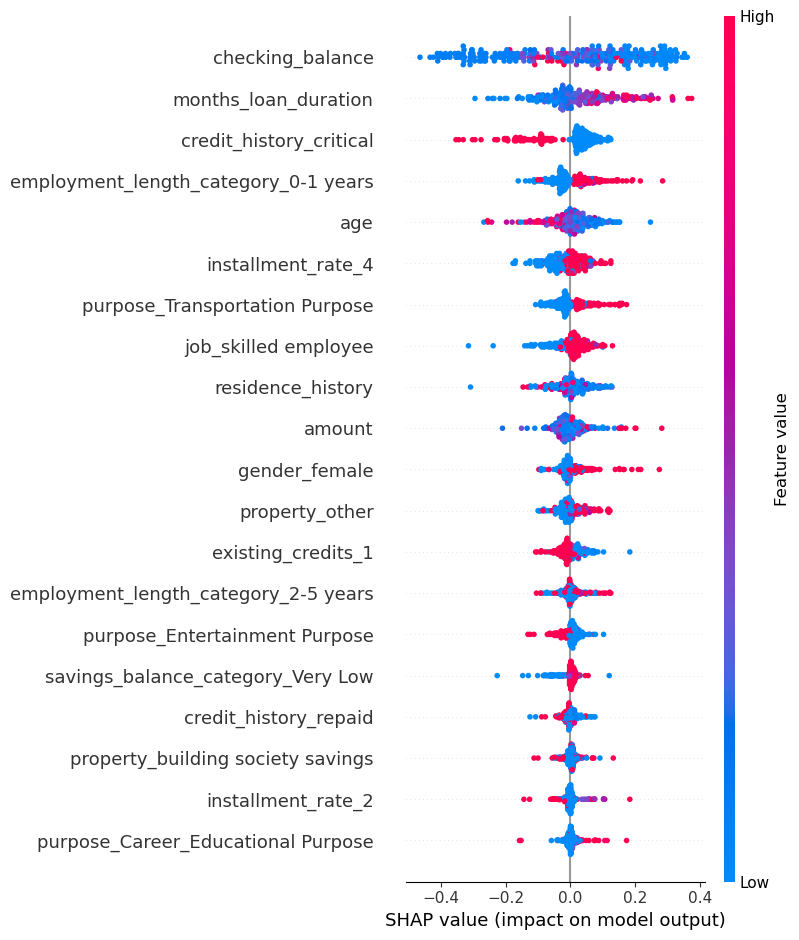

Optimal threshold: 0.20
Maximum net benefit: €1,164,000
Estimated defaults prevented: 127
Associated opportunity cost: €106,000
### Feature Impact Summary ###

Top Features based on SHAP values:
Feature: checking_balance, Mean Absolute SHAP Value: 0.1836
Feature: months_loan_duration, Mean Absolute SHAP Value: 0.0808
Feature: credit_history_critical, Mean Absolute SHAP Value: 0.0672
Feature: employment_length_category_0-1 years, Mean Absolute SHAP Value: 0.0469
Feature: age, Mean Absolute SHAP Value: 0.0461
Feature: installment_rate_4, Mean Absolute SHAP Value: 0.0394
Feature: purpose_Transportation Purpose, Mean Absolute SHAP Value: 0.0367
Feature: job_skilled employee, Mean Absolute SHAP Value: 0.0352
Feature: residence_history, Mean Absolute SHAP Value: 0.0341
Feature: amount, Mean Absolute SHAP Value: 0.0321

Top Features based on Model's Feature Importance:
Feature: checking_balance, Importance: 14.8753
Feature: months_loan_duration, Importance: 7.5485
Feature: age, Importance: 5.

In [22]:
impact_df, optimal = analyze_business_impact(y_test,X_test,model, avg_loan=10000)

## Model Evaluation Metrics:


**Model Evaluation Metrics:**

| Metric             | Value    | Description                                                                                                                                                    |
|----------------------|----------|----------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Accuracy             | 84.42%   | Percentage of correctly classified applications. Can be misleading in imbalanced datasets.                                                                     |
| Sensitivity/Recall   | 87.97%   | Percentage of actual defaults correctly identified. Crucial for minimizing losses.                                                                          |
| Specificity          | 81.12%   | Percentage of non-defaults correctly identified.                                                                                                                |
| Precision            | 81.25%   | Of those predicted to default, the percentage that actually defaulted. High precision means fewer false positives.                                           |
| F1-Score             | 84.36%   | The harmonic mean of precision and recall, providing a balanced measure.                                                                                       |
| AUC                  | 0.94     | Measures the model's ability to distinguish between classes. 0.5 is random guessing, 1.0 is perfect.                                                              |
| Beta Score           | 86.44%   | A weighted average of precision and recall, where β controls the balance (β=1 is the F1 score).                                                               |


**Interpretation:**

The model demonstrates a strong performance across multiple metrics.  The high accuracy (84.42%) indicates a good overall classification rate. The recall (87.97%) shows the model's effectiveness in identifying actual defaults, which is critical for minimizing financial losses. The specificity (81.12%) demonstrates a reasonable ability to correctly classify non-defaults. The precision (81.25%) indicates that when the model predicts a default, it is generally correct, though there's a small trade-off with recall. The high AUC score (0.94) indicates excellent discriminatory power, suggesting the model is very capable of distinguishing between defaulters and non-defaulters. The F1-score (84.36%) and Beta Score (86.44%) further confirm the model's strong and balanced performance, considering both precision and recall.ion and recall.atory power.

**Feature Importance Analysis:**

The following table summarizes the feature importances derived from the model, providing insights into the relative contribution of each feature to the prediction of loan defaults:

| Feature                     | Importance | Category                    |
|------------------------------|------------|-----------------------------|
| `checking_balance`           | 11.98      | Current Financial Situation |
| `amount`                     | 10.83      | Current Financial Situation |
| `age`                        | 10.35      | Personal Characteristics    |
| `residence_history`          | 9.83       | Personal Characteristics    |
| `months_loan_duration`       | 8.31       | Loan Terms                  |
| `purpose`                    | 7.28       | Loan Details                |
| `installment_rate`           | 6.91       | Loan Terms                  |
| `credit_history`             | 6.76       | Credit History              |
| `employment_length_category` | 6.37       | Employment History          |
| `property`                   | 5.21       | Assets/Collateral           |
| `job`                        | 3.10       | Employment Details          |
| `gender`                     | 3.00       | Personal Characteristics    |
| `savings_balance_category`   | 2.73       | Savings                     |
| `existing_credits`           | 2.67       | Credit History              |
| `housing`                    | 2.40       | Housing                     |
| `personal_status`            | 1.20       | Personal Characteristics    |
| `dependents`                 | 1.06       | Personal Circumstances      |

**Interpretation:**

The features can be broadly categorized as follows, based on their importance:

*   **Key Predictors:** `checking_balance`, `amount`, `age`, `residence_history`, and `months_loan_duration` are the most influential features. This suggests that a customer's current financial situation (checking balance, loan amount), personal characteristics (age, residence history), and loan terms (loan duration) are the strongest predictors of default.
*   **Moderate Predictors:** `purpose`, `installment_rate`, `credit_history`, and `employment_length_category` contribute moderately to the model's predictions. These provide further context regarding the loan's purpose, affordability, credit history, and employment stability.
*   **Less Important Features:** Features like `property`, `job`, `gender`, `savings_balance_category`, `existing_credits`, `housing`, `personal_status`, and `dependents` have relatively lower importance scores. While they might have some minor influence, they are less crucial for predicting default ccal and non-technical audiences.

## ***Business Impact Assessment:** 

**Estimating the Business Impact of Model Deployment:**

To estimate the potential business impact, we need to consider the financial implications of the model's predictions. This involves quantifying the benefits of reducing defaults against the costs of rejecting potentially good loan applications.

**Key Metrics and Costs (Example Values - Replace with your actual data):**

*   **Average Loan Amount:** €10,000 (Euro)
*   **Historical Default Rate (Baseline):** 5% (Without the model)
*   **Cost of a Default (CoD):** €10,000 (Loss of principal, interest, recovery costs)
*   **Cost of Rejecting a Good Applicant (CoR):** €1,000 (Lost potential profit)
*   **Monthly Loan Applications:** 1,000

**Model Performance Metrics (Updated from previous responses):**

*   **Accuracy:** 84.42%
*   **Sensitivity (Recall):** 87.97%
*   **Specificity:** 81.12%
*   **Precision:** 81.25%

**Calculations:**

1.  **Expected Defaults Without the Model:** 1,000 applications * 5% default rate = 50 defaults

2.  **Model Predictions:**
    *   **True Positives (TP):** 50 actual defaults * 87.97% sensitivity ≈ 44 defaults correctly predicted (rounded)
    *   **False Negatives (FN):** 50 - 44 = 6 defaults missed by the model
    *   **False Positives (FP):** Using Precision: 81.25% = TP / (TP + FP) => 0.8125 = 44 / (44 + FP) => FP ≈ 10 (rounded)

3.  **Financial Impact:**
    *   **Losses Without Model:** 50 defaults * €10,000/default = €500,000
    *   **Losses With Model (Due to False Negatives):** 6 FN * €10,000/default = €60,000
    *   **Cost of False Positives:** 10 FP * €1,000/rejected applicant = €10,000
    *   **Net Savings (Monthly):** €500,000 - €60,000 - €10,000 = €430,000



**Conclusion:**

Based on the example values and the *updated* model performance metrics, deploying the model could potentially save the lending institution approximately €430,000 per month by reducing loan losses. However, the actual impact will depend on the accuracy of the cost estimates, the model's performance on unseen data, and other factors. A more detailed analysis using real-world data and considering the additional factors mentioned above is recommended for a more precise estimation. The model also offers benefits beyond direct financial savings, such as improved risk management, operational efficiency, and customer satisfaction.